In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

Mounted at /content/drive


In [ ]:
!unzip drive/My\ Drive/ModelData.zip

Archive:  drive/My Drive/ModelData.zip
   creating: ModelData/
  inflating: ModelData/vectorize.py  
   creating: ModelData/train/
   creating: ModelData/train/forms/
  inflating: ModelData/train/forms/form10_page0.jpg  
  inflating: ModelData/train/forms/form10_page1.jpg  
  inflating: ModelData/train/forms/form10_page2.jpg  
  inflating: ModelData/train/forms/form10_page3.jpg  
  inflating: ModelData/train/forms/form7_page0.jpg  
  inflating: ModelData/train/forms/form7_page1.jpg  
  inflating: ModelData/train/forms/form7_page2.jpg  
  inflating: ModelData/train/forms/form7_page3.jpg  
  inflating: ModelData/train/forms/form7_page4.jpg  
  inflating: ModelData/train/forms/form2_page0.jpg  
  inflating: ModelData/train/forms/form5_page0.jpg  
  inflating: ModelData/train/forms/form5_page1.jpg  
  inflating: ModelData/train/forms/form5_page2.jpg  
  inflating: ModelData/train/forms/form5_page3.jpg  
  inflating: ModelData/train/forms/form5_page4.jpg  
  inflating: ModelData/train/forms

In [ ]:
PATH = os.path.join(os.path.dirname("ModelData/"), 'ModelData')

validation_dir = 'ModelData/validation/'
train_dir = "ModelData/train/"

BATCH_SIZE = 10
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

Found 437 files belonging to 8 classes.


In [ ]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 149 files belonging to 8 classes.


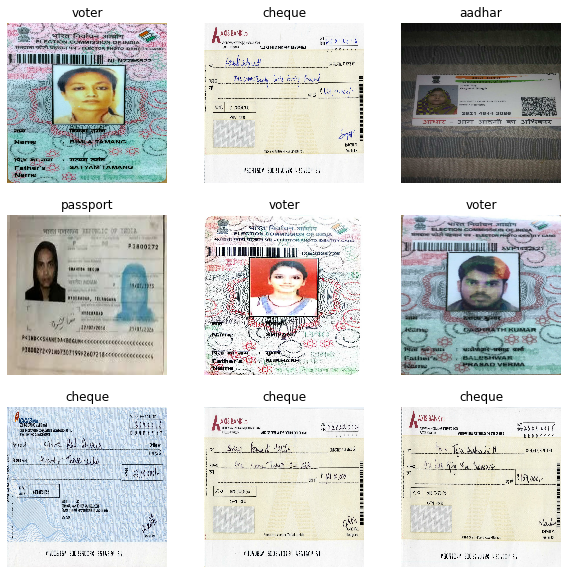

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(10, 5, 5, 1280)


In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 80, 80, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 80, 80, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 80, 80, 32)   0           ['bn_Conv1[0][

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)



(10, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(10, 1)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_1 (TFOpLamb  (None, 160, 160, 3)      0         
 da)                                                             
                                                                 
 tf.math.subtract_1 (TFOpLam  (None, 160, 160, 3)      0         
 bda)                                                            
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                           

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

12/12 [==============================] - 4s 151ms/step - loss: 3.1924 - accuracy: 0.1176


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
44/44 [==============================] - 16s 267ms/step - loss: -0.5432 - accuracy: 0.1281 - val_loss: -0.7299 - val_accuracy: 0.0756
Epoch 2/10
44/44 [==============================] - 12s 266ms/step - loss: -4.5465 - accuracy: 0.2471 - val_loss: -4.1157 - val_accuracy: 0.2017
Epoch 3/10
44/44 [==============================] - 12s 263ms/step - loss: -8.2008 - accuracy: 0.2563 - val_loss: -6.5503 - val_accuracy: 0.2101
Epoch 4/10
44/44 [==============================] - 12s 264ms/step - loss: -11.7969 - accuracy: 0.2563 - val_loss: -9.2009 - val_accuracy: 0.2017
Epoch 5/10
44/44 [==============================] - 12s 262ms/step - loss: -15.3631 - accuracy: 0.2563 - val_loss: -13.3509 - val_accuracy: 0.2101
Epoch 6/10
44/44 [==============================] - 12s 263ms/step - loss: -19.0518 - accuracy: 0.2563 - val_loss: -15.3479 - val_accuracy: 0.1933
Epoch 7/10
44/44 [==============================] - 12s 261ms/step - loss: -22.3758 - accuracy: 0.2563 - val_loss: -18.5095 -

In [1]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

NameError: ignored